In [1]:
import netCDF4 as nc
import math
import numpy as np
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
h1 = nc.Dataset('S5P_OFFL_L1C_SIFTPC_20240206T123417_20240206T123957_32732_93_000001_20241120T170117.nc')
africa = h1.groups['africa']

In [3]:
#Identify scanline in groundpixel 224 with clouds
scanline = africa.variables['scanline']
groundpixel = africa.variables['ground_pixel']

#Remove all scanlines where there is one groundpixel that has a cloud in that combination/ coordinate 
scanline_nocloud = []
for n in range(406):
    if (africa.variables['CloudFraction'][0,n,224:240]<0.4).all():
        scanline_nocloud.append(n)
len(scanline_nocloud)

317

In [4]:
#Fixing albedo 
import numpy.polynomial.polynomial as po
def indexate(wl, ranges):
    if isinstance(ranges[0], (int, float)):  # Single range
        start, end = ranges
        return np.where((wl >= start) & (wl <= end))[0]
    else:  # Multiple ranges
        indices = np.concatenate([np.where((wl >= start) & (wl <= end))[0] for start, end in ranges])
        return np.sort(indices)
#len(africa.variables['Reflectance_wl'][0, 0 , 224, :]) ##this is how you check when reflectance wavelength starts and ends and its length
wl = np.linspace(700.06,785.16,692) #Define the wavelenth in terms of the spectral channels 
retrievalWindow = (734, 758) # retrieval wavelength window [nm]
windowsOfNoAbsorption = ((712, 713), (748, 757), (775, 785)) # windows for no atmospheric absorption [nm]
sb_order = 4 # order of polynomial fit of surface reflectivity (barren)
ind    = indexate(wl, retrievalWindow)
ind_na = indexate(wl, windowsOfNoAbsorption)
ref_na = africa.variables["Reflectance"][0, :, 224, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_albedo = np.zeros((len(scanline_nocloud), 195))
for idx, i in enumerate(scanline_nocloud):
    poly_sa = po.polyfit (wl[ind_na], ref_na[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa)
    surf_albedo[idx, :] = surf_alb

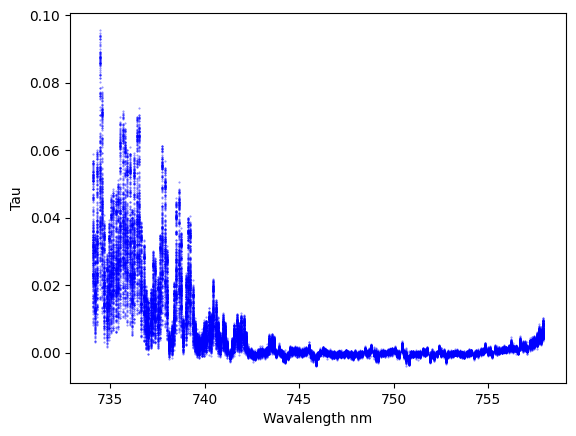

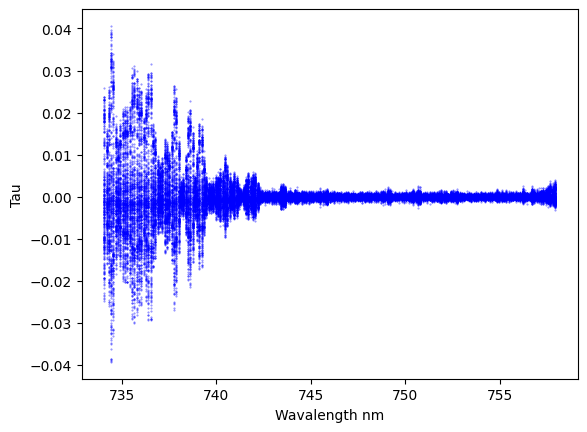

Centered data shape: (317, 195)
Mean after centering: 3.3030886123015795e-17


In [5]:
#Computing tau
mu = np.cos(np.radians(africa.variables["VZA"][0,scanline_nocloud,224]))
mu_0 = np.cos(np.radians(africa.variables["SZA"][0,scanline_nocloud,224]))
mu_matrix = np.tile(mu[:, np.newaxis], 195)
mu_0_matrix = np.tile(mu_0[:, np.newaxis], 195)
reflectance_matrix = africa.variables['Reflectance'][0, scanline_nocloud, 224, 276:471].data
angles = (mu_matrix + mu_0_matrix)/mu_matrix*mu_0_matrix
tau = -np.log(reflectance_matrix/surf_albedo)/angles

for idx, i  in enumerate(scanline_nocloud):
    plt.scatter(wl[ind], tau[idx],color='blue', alpha = 0.5, s= 0.2)
    plt.xlabel('Wavalength nm')
    plt.ylabel('Tau')
    #what is the unit?? 
plt.show()

# Center data
mean_spectrum = np.mean(tau, axis=0)
tau_centered = tau - mean_spectrum
for idx, i  in enumerate(scanline_nocloud):
    plt.scatter(wl[ind], tau_centered[idx],color='blue', alpha = 0.5, s= 0.2)
    plt.xlabel('Wavalength nm')
    plt.ylabel('Tau')
    #what is the unit?? 
plt.show()

# Verify
print("Centered data shape:", tau_centered.shape)
print("Mean after centering:", np.mean(tau_centered, axis=0).max())  # Should be ~0

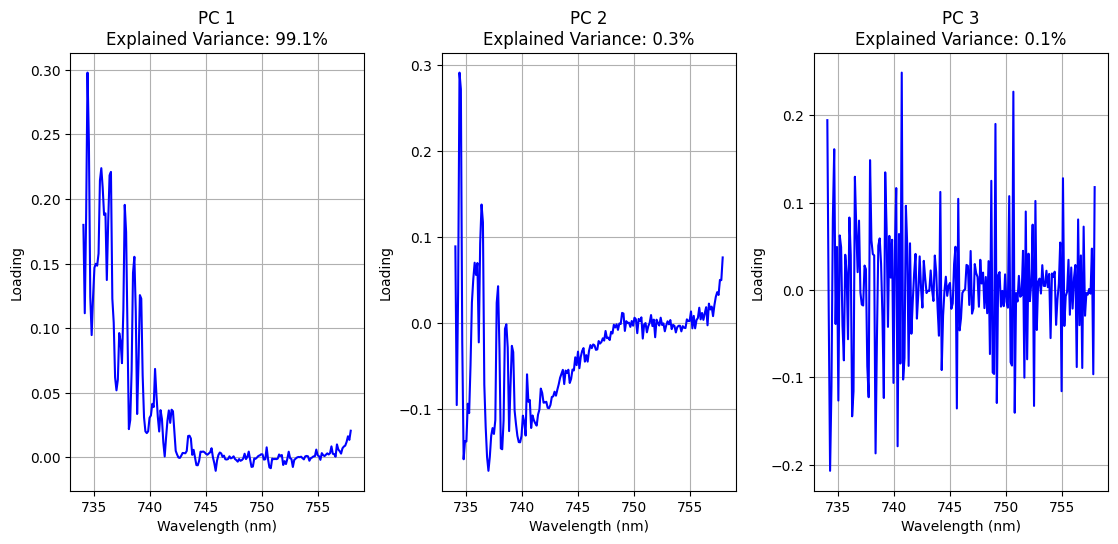

Explained variance by 10 PCs: 99.65%


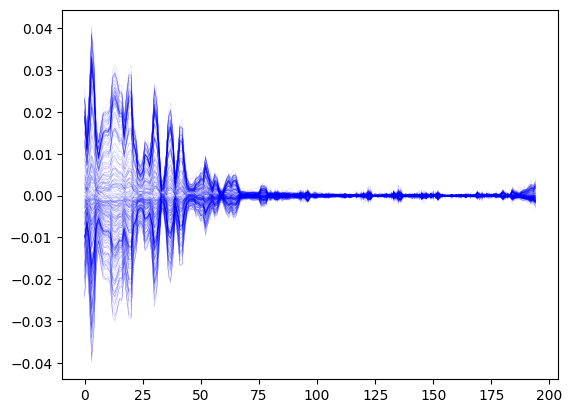

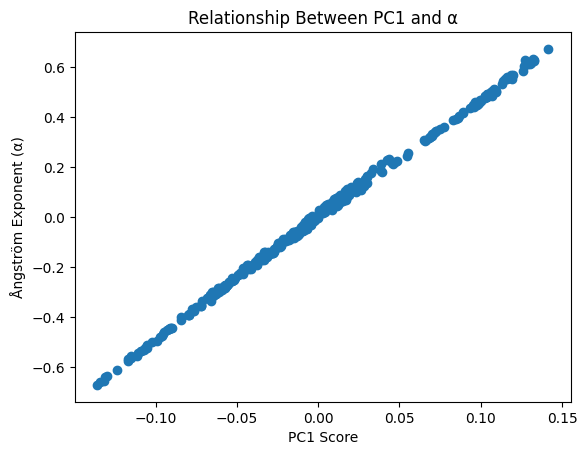

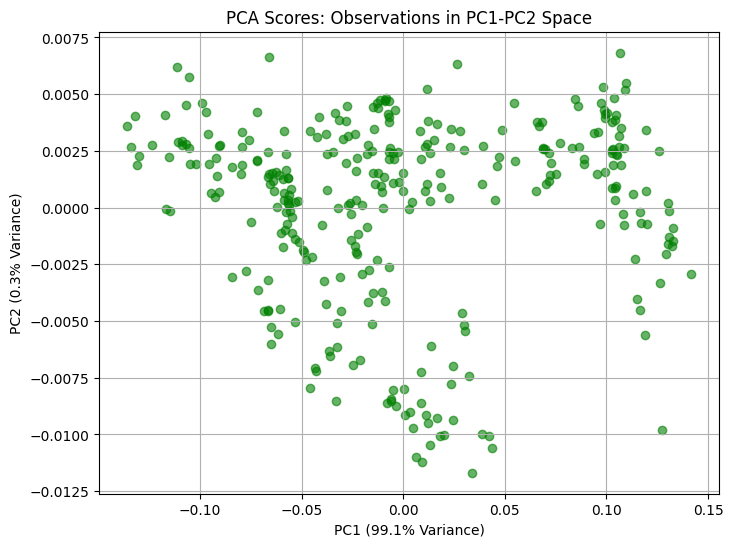

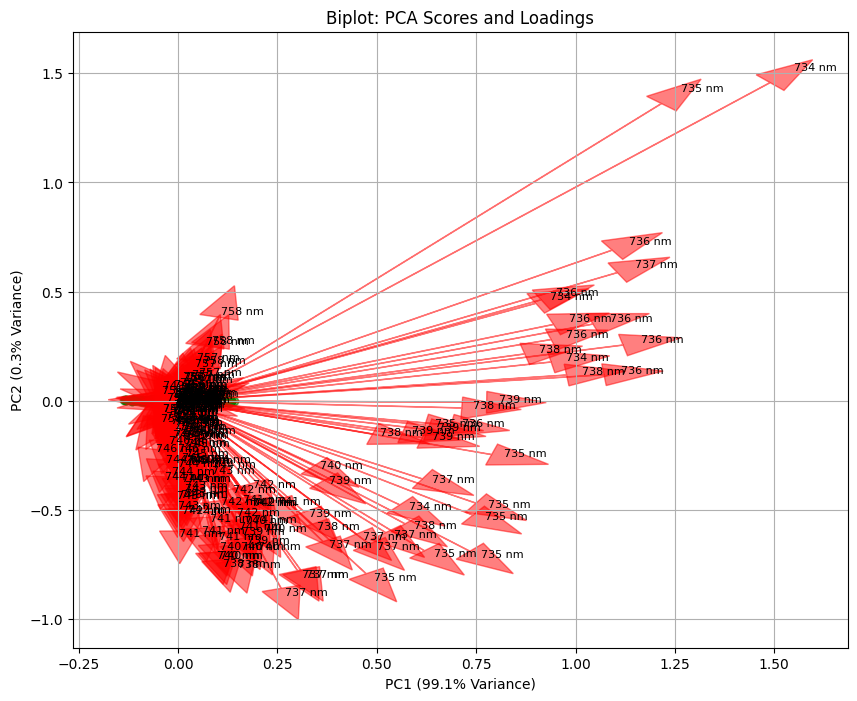

In [6]:
from sklearn.decomposition import PCA
from scipy.stats import linregress
pca = PCA(n_components=15).fit(tau_centered)
components = pca.components_

plt.figure(figsize=(15, 20))
for i in range(3):
    plt.subplot(4, 4, i+1)  # 4x4 grid
    plt.plot(wl[ind], components[i], color='blue')
    plt.title(f'PC {i+1}\nExplained Variance: {pca.explained_variance_ratio_[i]*100:.1f}%')
    plt.xlabel("Feature Index" if wl[ind] is None else "Wavelength (nm)")
    plt.ylabel("Loading")
    plt.grid(True)
plt.tight_layout()
plt.savefig("PCA_tau")
plt.show()

print(f"Explained variance by 10 PCs: {np.sum(pca.explained_variance_ratio_):.2%}")

tau_pca = pca.transform(tau_centered)  # Shape: (317, 10)
tau_reconstructed = pca.inverse_transform(tau_pca)  # Shape: (317, 195)
plt.plot(tau_reconstructed.T,color='blue', alpha = 0.5, linewidth = 0.1)
plt.show()

# Use PC1 scores (most dominant component) as a predictor
pc1_scores = tau_pca[:, 0]

# Fit τ = β ⋅ λ^(-α) using PC1 as a proxy for wavelength dependence
log_w = np.log(wl[ind])
log_tau = np.log(tau_centered + 1)  # Avoid log(0)

# Fit regression for each observation (317 total)
alpha_values = []
beta_values = []
for i in range(tau.shape[0]):
    slope, intercept, _, _, _ = linregress(log_w, log_tau[i])
    alpha_values.append(-slope)
    beta_values.append(np.exp(intercept))

# Compare α with PC1 scores (dominant variability)
plt.scatter(pc1_scores, alpha_values)
plt.xlabel('PC1 Score')
plt.ylabel('Ångström Exponent (α)')
plt.title('Relationship Between PC1 and α')
plt.show()

# Project data to PCA space
tau_pca = pca.transform(tau_centered)  # Shape: (317, 10)

# Scatter plot of scores for PC1 vs. PC2
plt.figure(figsize=(8, 6))
plt.scatter(tau_pca[:, 0], tau_pca[:, 1], alpha=0.6, c='green')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} Variance)')
plt.title('PCA Scores: Observations in PC1-PC2 Space')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(tau_pca[:, 0], tau_pca[:, 1], alpha=0.6, c='green', label='Observations')

# Plot eigenvectors as arrows
for i, (x, y) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.arrow(0, 0, x*5, y*5, color='red', alpha=0.5, head_width=0.1)
    plt.text(x*5.2, y*5.2, f'{wl[ind][i]:.0f} nm', color='black', fontsize=8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} Variance)')
plt.title('Biplot: PCA Scores and Loadings')
plt.grid(True)
plt.show()

In [7]:
##SIF-retrieval 

In [8]:
#SOLAR IRRADIANCE FROM ? 
E = nc.Dataset('S5P_OPER_REF_SOLAR__00000000T000000_99999999T999999_20210107T132455.nc')
groups = E.groups
E_0 = E.groups['band_6']

wavelength = E_0["wavelength"][:]
indices = np.where((wavelength >= 734) & (wavelength <= 758))[0]
# Get irradiance_flux and subset the desired range
irradiance_flux = E_0["irradiance_flux_cf"][0, indices]
num_pixels = len(irradiance_flux)
target_size = 195
step = num_pixels // target_size  
# Average over non-overlapping groups of ground pixels
irradiance_vector = np.squeeze(np.mean(irradiance_flux[:step*target_size].reshape(target_size, step, -1), axis=1))

#CONVERTING UNITS --- Convert irradiance from mol s⁻¹ m⁻² nm⁻¹ to W m⁻² nm⁻¹
def convert_irradiance(irradiance_mol, wavelength_nm):
            """
            Convert irradiance from mol s⁻¹ m⁻² nm⁻¹ to W m⁻² nm⁻¹.
           
            Parameters:
                irradiance_mol (array): Irradiance in mol s⁻¹ m⁻² nm⁻¹
                wavelength_nm (array): Corresponding wavelengths in nm
               
            Returns:
                array: Irradiance in mW m⁻² nm⁻¹            """
            # Constants
            h = 6.626e-34  # Planck's constant (J·s)
            c = 2.998e8    # Speed of light (m/s)
            Na = 6.022e23  # Avogadro's number (photons/mol)
           
            wavelength_m = np.array(wavelength_nm) * 1e-9  # Convert nm to meters
            photon_energy = (h * c) / wavelength_m  # Energy per photon in Joules
            irradiance_watts = irradiance_mol * Na * photon_energy  # Convert to W/m²/nm
       
            irradiance_mW = irradiance_watts * 1000
            return irradiance_mW
       
solspec = convert_irradiance(irradiance_vector, wl[ind])

(15, 195)
Fitted parameters:
[ 1.63715202e-01  1.05838368e-02 -6.69858434e-04 -1.11181058e-04
  4.08499368e-03  1.42578552e-04 -1.01966431e-03  1.90880259e-03
  3.59410844e-04  8.99399559e-04 -1.92422609e-04 -9.51125171e-04
 -7.20576014e-04  5.77122174e-04 -7.17034719e-04 -2.14807526e-07]


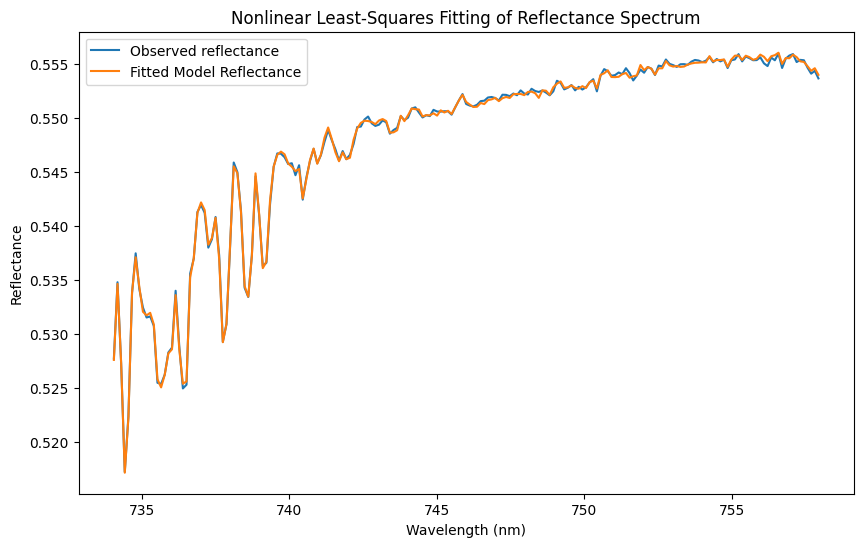

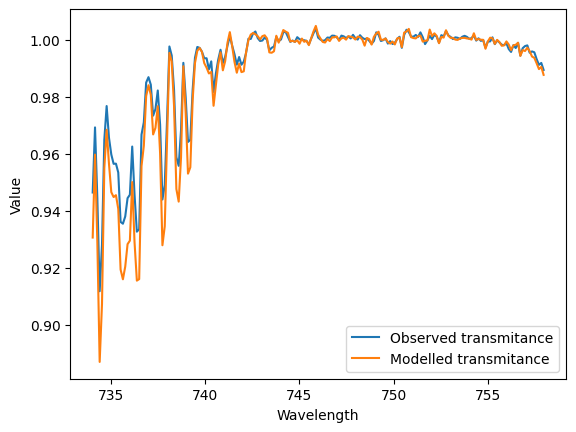

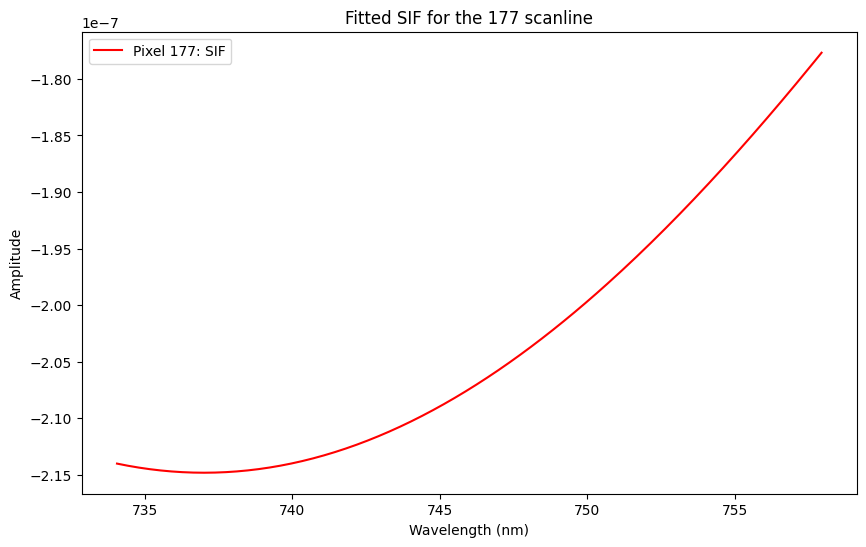

In [9]:
f_matrix = components
print(f_matrix.shape)
n = len(f_matrix)
reflectance_observed = africa.variables['Reflectance'][0, scanline_nocloud[100], 224, 276:471].data
pixel_index = 100
def reflectance_model(lam, *params):

    # Unpack parameters
    b = np.array(params[0:n])
    c = params[n]
    
    # Compute the weighted sum over the principal component spectral functions:
    attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
    
    # Baseline reflectance term:
    baseline = surf_albedo[pixel_index] * np.exp(-attenuation)
    
    # Gaussian term for the fluorescence component:
    gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
    
    # Geometric factor for the fluorescence attenuation:
    geom_factor = (1 / mu_matrix[pixel_index]) / ((1 / mu_matrix[pixel_index]) + (1 / mu_0_matrix[pixel_index]))
    
    # Fluorescence (SIF) term:
    fluorescence = (np.pi * c * gaussian /( mu_0_matrix[pixel_index] )) * np.exp(-attenuation * geom_factor)
    
    # Total modeled reflectance:
    return baseline + fluorescence

# Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
p0 = [0.5] * n + [0.5]
# lower_bounds = [0] * n + [0]  # Allow b parameters to be anything, but c must be ≥ 0
# upper_bounds = [np.inf] * n + [np.inf]  # No upper bound on any parameter

# Fit the model to the observed reflectance
popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0)#, bounds=(lower_bounds, upper_bounds),maxfev=10000)

print("Fitted parameters:")
print(popt)

# ---- Plot the results ----

R_fit = reflectance_model(wl[ind], *popt)

plt.figure(figsize=(10, 6))
plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
plt.savefig("LM-fitting_PCA")
plt.legend()
plt.show()

#Plot transmittance observed and modelled
transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix) + np.reciprocal(mu_0_matrix))*tau)[100]
# Extract the fitted PCA coefficients (b0 to b9)
b_fit = np.array(popt[0:n])
# Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)

transmitance_modelled = np.exp(-(np.reciprocal(mu_matrix[100]) + np.reciprocal(mu_0_matrix[100]))*attenuation_fit)
plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend(loc="best")
plt.savefig("ML_fit_transmitance_PCA")
plt.show()
# Pre-compute the Gaussian (same for every pixel if center and width are fixed)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)

# For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
plt.figure(figsize=(10, 6))
plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {scanline_nocloud[100]}: SIF", color='red')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Amplitude")
plt.title("Fitted SIF for the 177 scanline")
plt.legend()
plt.savefig("ML_fit_SIF_PCA")
plt.show()


In [10]:
f_matrix = components
print(f_matrix.shape)
n = len(f_matrix)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
SIF_values_per_scanline = []
for pixel_index, i in enumerate(scanline_nocloud):
    reflectance_observed = africa.variables['Reflectance'][0, i, 224, 276:471].data
    def reflectance_model(lam, *params):
    
        # Unpack parameters
        b = np.array(params[0:n])
        c = params[n]
        
        # Compute the weighted sum over the principal component spectral functions:
        attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
        # Baseline reflectance term:
        baseline = surf_albedo[pixel_index] * np.exp(-attenuation)
        
        # Gaussian term for the fluorescence component:
        gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
        # Geometric factor for the fluorescence attenuation:
        geom_factor = (1 / mu_matrix[pixel_index]) / ((1 / mu_matrix[pixel_index]) + (1 / mu_0_matrix[pixel_index]))
        
        # Fluorescence (SIF) term:
        fluorescence = (np.pi * c * gaussian /( mu_0_matrix[pixel_index] * solspec)) * np.exp(-attenuation * geom_factor)
        
        # Total modeled reflectance:
        return baseline + fluorescence
    
    # Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
    p0 = [0.5] * n + [0.5]
    # lower_bounds = [-np.inf] * n + [0]  # Allow b parameters to be anything, but c must be ≥ 0
    # upper_bounds = [np.inf] * n + [np.inf]  # No upper bound on any parameter
    
    # Fit the model to the observed reflectance
    popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0)#, bounds=(lower_bounds, upper_bounds),maxfev=10000)

    SIF_values_per_scanline.append(popt[-1])

(15, 195)


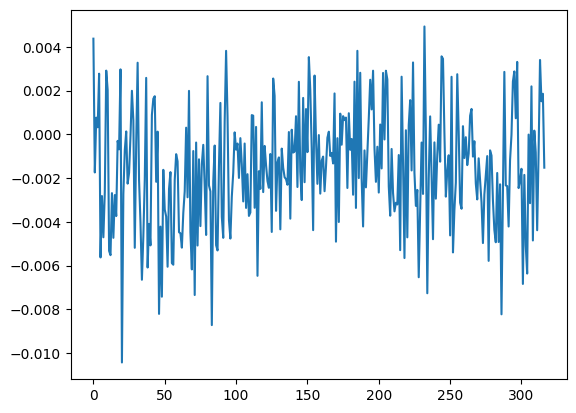

-0.001562686950976313


In [11]:
plt.plot(SIF_values_per_scanline)
plt.show()
print(np.mean(SIF_values_per_scanline))

In [12]:
# f_matrix = components
# print(f_matrix.shape)
# n = len(f_matrix)
# SIF_values_per_scanline2 = []
# for pixel_index, i in enumerate(scanline_nocloud2):
#     reflectance_observed = africa2.variables['Reflectance'][0, i, 224, 276:471].data
#     m = 2
#     def reflectance_model(lam, *params):

#         # Unpack parameters
#         a = np.array(params[0:m]) 
#         b = np.array(params[m:n+m])
#         c = params[n+m]
        
#         # Compute the weighted sum over the principal component spectral functions:
#         attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
#         poly_term = sum(a[j] * lam**j for j in range(m))
#         baseline = poly_term * np.exp(-attenuation)
    
#         # Gaussian term for the fluorescence component:
#         gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
#         # Geometric factor for the fluorescence attenuation:
#         geom_factor = (1 / mu_matrix2[pixel_index]) / ((1 / mu_matrix2[pixel_index]) + (1 / mu_0_matrix2[pixel_index]))
        
#         # Fluorescence (SIF) term:
#         fluorescence = (np.pi * c * gaussian /( mu_0_matrix2[pixel_index] * solspec)) * np.exp(-attenuation * geom_factor)
        
#         # Total modeled reflectance:
#         return baseline + fluorescence

# # Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
#     p0 = [0.5]*m + [0.5] * n + [0.5]

#     popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0)

#     SIF_values_per_scanline2.append(popt[-1])

(15, 195)


NameError: name 'scanline_nocloud2' is not defined

In [ ]:
# plt.plot(SIF_values_per_scanline2)
# plt.show()
# print(np.mean(SIF_values_per_scanline2))

In [ ]:
# # Prepare an array to store the fitted c_gaussian for each pixel.
# # We'll store the full vector for each pixel in a list.
# c_gaussian_list = []  
# fitted_c_list = []   # Optionally store just the fitted c value for each pixel

# # Loop over each pixel index in your scanline (assuming scanline_nocloud is an array of pixel indices)
# for pixel_index, i in enumerate(scanline_nocloud):
#     # Extract the reflectance spectrum for this pixel. Adjust indices as necessary.
#     # Here we assume the reflectance array has dimensions [time, scanline, row, column]
#     # and that 'pixel_index' indexes the spatial dimension you wish to loop over.
#     reflectance_observed = africa.variables['Reflectance'][0, i, 224, 276:471].data

#     try:
#         # Fit the model to the observed reflectance
#         popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0, maxfev=10000)
        
#         # Extract the fitted parameter c (index 10)
#         fitted_c = popt[n]
#         fitted_c_list.append(fitted_c)
        
#         # Compute c * gaussian for the current pixel over the wavelength range
#         c_gaussian = fitted_c * gaussian_full
        
#         # Append the computed vector to the list
#         c_gaussian_list.append(c_gaussian)
        
#     except Exception as e:
#         print(f"Fit failed for pixel {pixel_index}: {e}")
#         # Append NaN array to preserve index if needed
#         c_gaussian_list.append(np.full_like(gaussian_full, np.nan))
#         fitted_c_list.append(np.nan)

# # For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
# plt.figure(figsize=(10, 6))
# plt.plot(wl[ind], c_gaussian_list[100], label=f"Pixel {scanline_nocloud[0]}: c*Gaussian", color='red')
# plt.xlabel("Wavelength (nm)")
# plt.ylabel("Amplitude")
# plt.title("Fitted c*Gaussian for the First Pixel")
# plt.legend()
# plt.show()

# # Optionally, if you want to visualize how the fitted c values vary over the scanline:
# plt.figure(figsize=(10, 6))
# plt.plot(scanline_nocloud, fitted_c_list, 'o-', label="Fitted c values")
# plt.xlabel("Pixel index")
# plt.ylabel("Fitted c")
# plt.title("Variation of Fitted c over Scanline")
# plt.legend()
# plt.show()
# print(fitted_c_list[100])

In [13]:
h2 = nc.Dataset('S5P_OFFL_L1C_SIFTPC_20240206T172817_20240206T173755_32735_93_000001_20241120T172637.nc')
africa2 = h2.groups['africa']

In [14]:
#Remove clouds
scanline_nocloud2 = []
for n in range(406):
    if (africa2.variables['CloudFraction'][0,n,224:240]<0.4).all():
        scanline_nocloud2.append(n)
sc_nc2 = len(scanline_nocloud2)


#Fixing albedo 

ref_na2 = africa2.variables["Reflectance"][0, scanline_nocloud2, 224, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_alb2 = np.zeros((sc_nc2, 195))
for i in range(sc_nc2):
    poly_sa = po.polyfit (wl[ind_na], ref_na2[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa) 
    surf_alb2[i, :] = surf_alb

#Computing tau
mu2 = np.cos(np.radians(africa2.variables["VZA"][0,scanline_nocloud2,224]))
mu_02 = np.cos(np.radians(africa2.variables["SZA"][0,scanline_nocloud2,224]))
mu_matrix2 = np.tile(mu2[:, np.newaxis], (1,195))
mu_0_matrix2 = np.tile(mu_02[:, np.newaxis],(1, 195))
reflectance_matrix2 = africa2.variables['Reflectance'][0, scanline_nocloud2, 224, 276:471]


tau2 = -np.log(reflectance_matrix2/surf_alb2)/ (np.reciprocal(mu_matrix2)+ np.reciprocal(mu_0_matrix2))
irradiance_matrix2 = np.tile(solspec.T, (sc_nc2, 1))

(15, 195)
Fitted parameters:
[ 2.56995856e-01  2.05988599e-01 -2.77742017e-02 -1.28368439e-01
  3.53397192e-02 -2.22880676e-03  1.08730409e-02 -2.55241929e-03
 -8.16507670e-03 -5.10767791e-03  7.50697021e-03 -2.62432287e-03
  1.14836912e-03  2.37795285e-03 -3.36859252e-03 -5.86728296e+00]


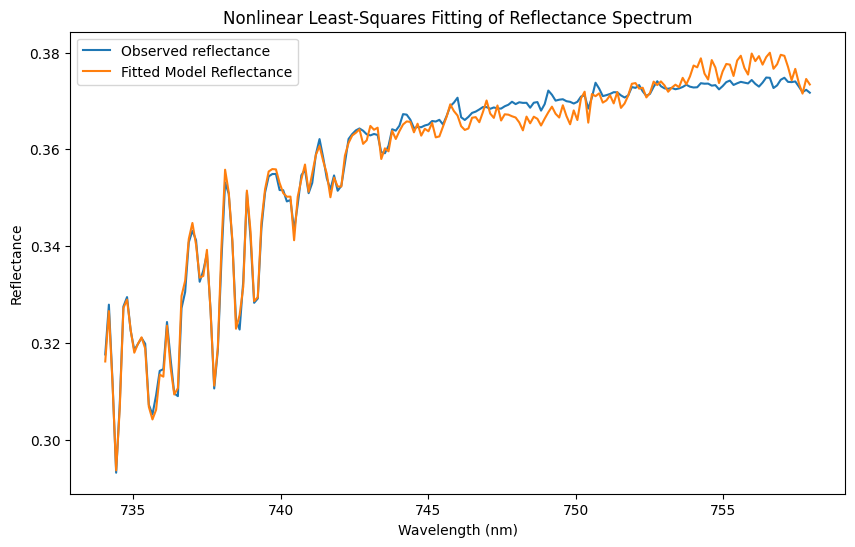

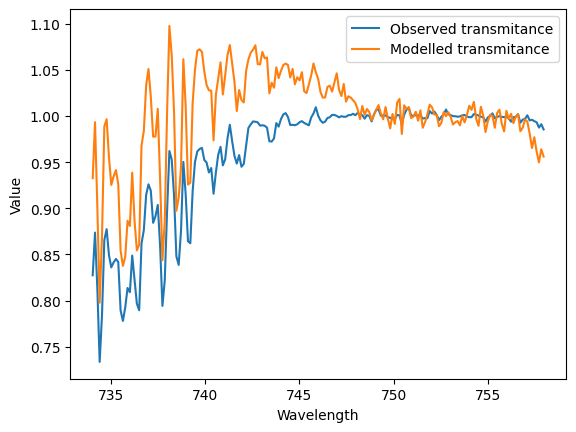

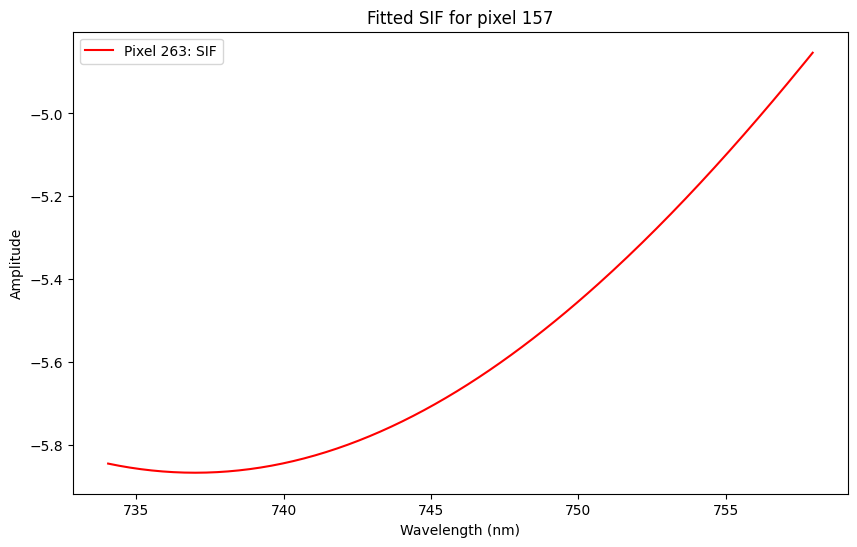

In [15]:
f_matrix = components
print(f_matrix.shape)
n = len(f_matrix)
pixel_index = 100
reflectance_observed = africa2.variables['Reflectance'][0, scanline_nocloud[pixel_index], 224, 276:471].data

def reflectance_model(lam, *params):

    # Unpack parameters
    b = np.array(params[0:n])
    c = params[n]
    
    # Compute the weighted sum over the principal component spectral functions:
    attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
    
    # Baseline reflectance term:
    baseline = surf_alb2[pixel_index] * np.exp(-attenuation)
    
    # Gaussian term for the fluorescence component:
    gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
    
    # Geometric factor for the fluorescence attenuation:
    geom_factor = (1 / mu_matrix2[pixel_index]) / ((1 / mu_matrix2[pixel_index]) + (1 / mu_0_matrix2[pixel_index]))
    
    # Fluorescence (SIF) term:
    fluorescence = (np.pi * c * gaussian /( mu_0_matrix2[pixel_index] * solspec)) * np.exp(-attenuation * geom_factor)
    
    # Total modeled reflectance:
    return baseline + fluorescence

# Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
p0 = [0.5] * n + [0.5]

popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0)

print("Fitted parameters:")
print(popt)

# ---- Plot the results ----

R_fit = reflectance_model(wl[ind], *popt)

plt.figure(figsize=(10, 6))
plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
plt.savefig("LM-fitting_PCA_A")
plt.legend()
plt.show()

#Plot transmittance observed and modelled
transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix2[100]) + np.reciprocal(mu_0_matrix2[100]))*tau2[100])
# Extract the fitted PCA coefficients (b0 to b9)
b_fit = np.array(popt[0:n])
# Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)

transmitance_modelled = np.exp(-(np.reciprocal(mu_matrix2[100]) + np.reciprocal(mu_0_matrix2[100]))*attenuation_fit)
plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend(loc="best")
plt.savefig("LM_fit_transmitance_PCA_A")
plt.show()
# Pre-compute the Gaussian (same for every pixel if center and width are fixed)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)

# For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
plt.figure(figsize=(10, 6))
plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {scanline_nocloud2[100]}: SIF", color='red')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Amplitude")
plt.title("Fitted SIF for pixel 157")
plt.legend()
plt.savefig("LM_fit_SIF_PCA_A")
plt.show()


Fitted parameters:
[1.23523545e-27 3.28439436e-28 6.17082149e-28 9.00531030e-10
 1.34060290e+00 4.03619526e-20 4.15059297e-03 1.15272980e-02
 1.86088958e-20 1.19346046e-02 4.86261202e-03 1.40394537e-21
 2.84137847e-18 1.43616176e-33 3.78549860e-03 1.31761656e-21
 1.46147456e-02 1.12793076e-20 4.34729405e-24 1.57125627e-26]


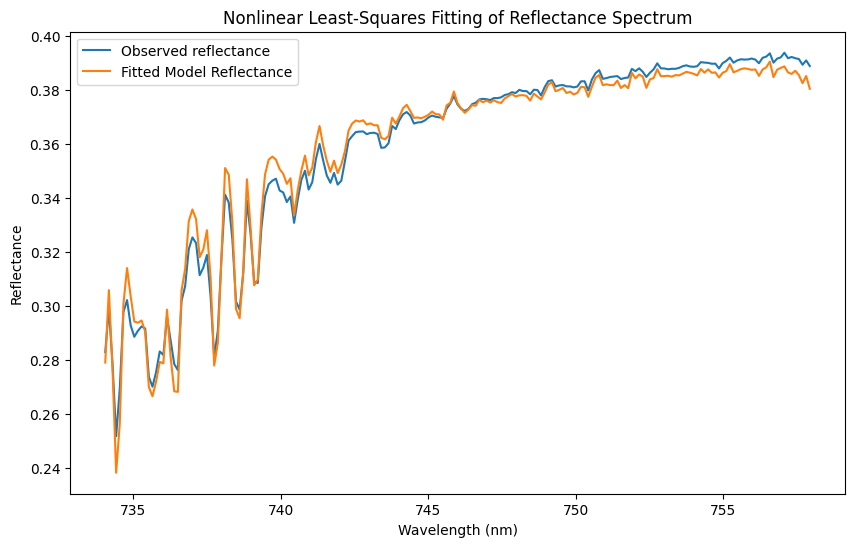

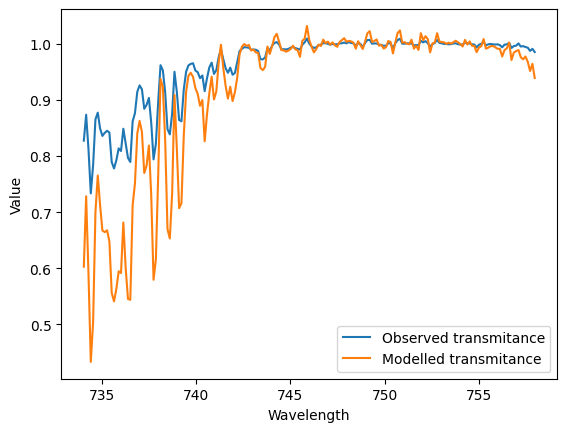

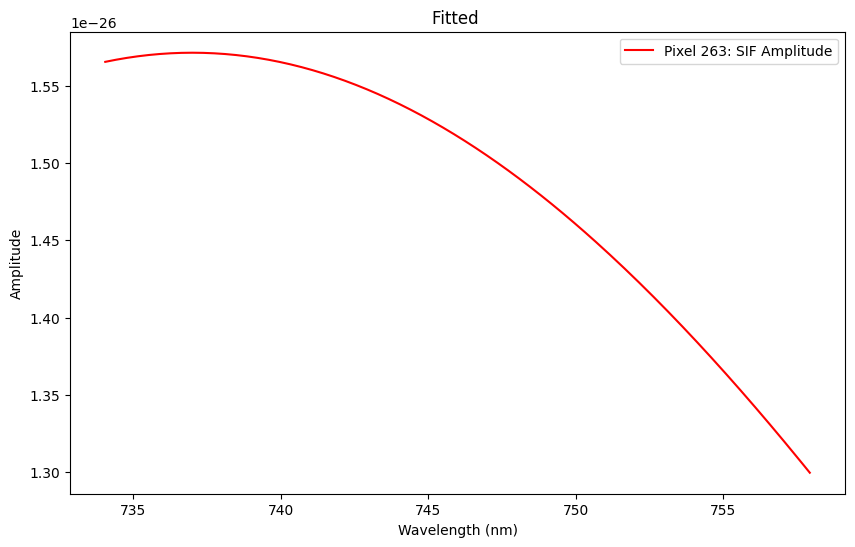

In [16]:
##With albedo fitting and bounds 
reflectance_observed = africa2.variables['Reflectance'][0, scanline_nocloud2[100], 224, 276:471].data

m = 4
def reflectance_model(lam, *params):

    # Unpack parameters
    a = np.array(params[0:m]) 
    b = np.array(params[m:n+m])
    c = params[n+m]
    
    # Compute the weighted sum over the principal component spectral functions:
    attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
    
    poly_term = sum(a[j] * lam**j for j in range(m))
    baseline = poly_term * np.exp(-attenuation)

    # Gaussian term for the fluorescence component:
    gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
    
    # Geometric factor for the fluorescence attenuation:
    geom_factor = (1 / mu_matrix2[pixel_index]) / ((1 / mu_matrix2[pixel_index]) + (1 / mu_0_matrix2[pixel_index]))
    
    # Fluorescence (SIF) term:
    fluorescence = (np.pi * c * gaussian /( mu_0_matrix2[pixel_index] * solspec)) * np.exp(-attenuation * geom_factor)
    
    # Total modeled reflectance:
    return baseline + fluorescence

# Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
p0 = [0.5]*m + [0.5] * n + [1]
lower_bounds = [0] * (n+m) + [0]
upper_bounds = [np.inf] * (n+m) + [np.inf]

popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0, bounds=(lower_bounds, upper_bounds))

print("Fitted parameters:")
print(popt)

# ---- Plot the results ----

R_fit = reflectance_model(wl[ind], *popt)

plt.figure(figsize=(10, 6))
plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
plt.savefig("LM-fitting_PCA_A")
plt.legend()
plt.show()

#Plot transmittance observed and modelled
transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix2[100]) + np.reciprocal(mu_0_matrix2[100]))*tau2[100])
# Extract the fitted PCA coefficients (b0 to b9)
b_fit = np.array(popt[m:n+m])
# Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)

transmitance_modelled = np.exp(-(np.reciprocal(mu_matrix2[100]) + np.reciprocal(mu_0_matrix2[100]))*attenuation_fit)
plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend(loc="best")
plt.savefig("LM_fit_transmitance_PCA_A")
plt.show()
# Pre-compute the Gaussian (same for every pixel if center and width are fixed)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)

# For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
plt.figure(figsize=(10, 6))
plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {scanline_nocloud2[100]}: SIF Amplitude", color='red')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Amplitude")
plt.title("Fitted ")
plt.legend()
plt.savefig("LM_fit_SIF_PCA_A")
plt.show()



Fitted parameters:
[-1.04474395e+00  1.88062947e-03  1.31972515e+00 -1.72979048e-01
  7.17494522e-03  4.76855222e-03 -1.02584424e-03  9.63116731e-03
  1.62963777e-02 -3.75661325e-03 -1.25872199e-03 -3.77303776e-03
  6.42729387e-03  1.25505589e-04  5.58278386e-03 -4.91102904e-03
 -2.78708462e-03  6.80817021e+00]


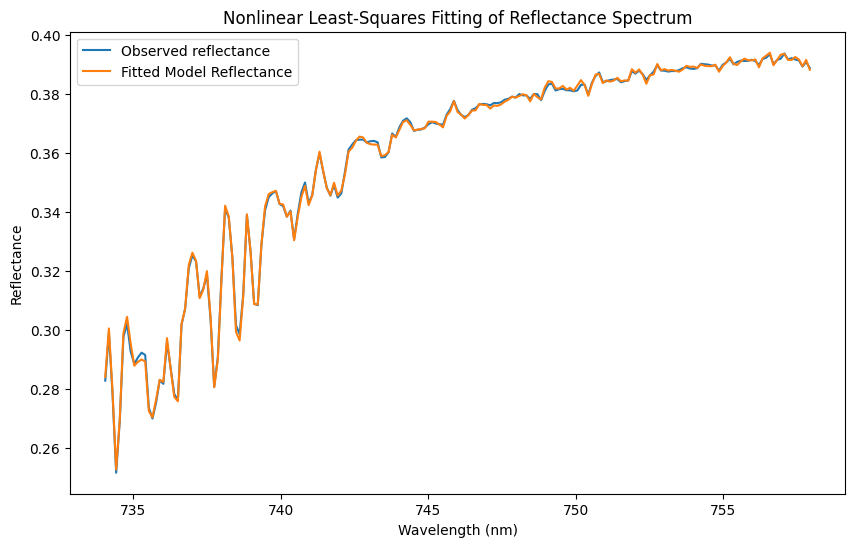

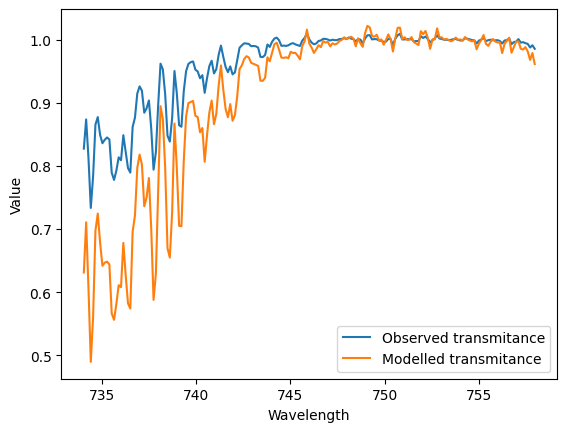

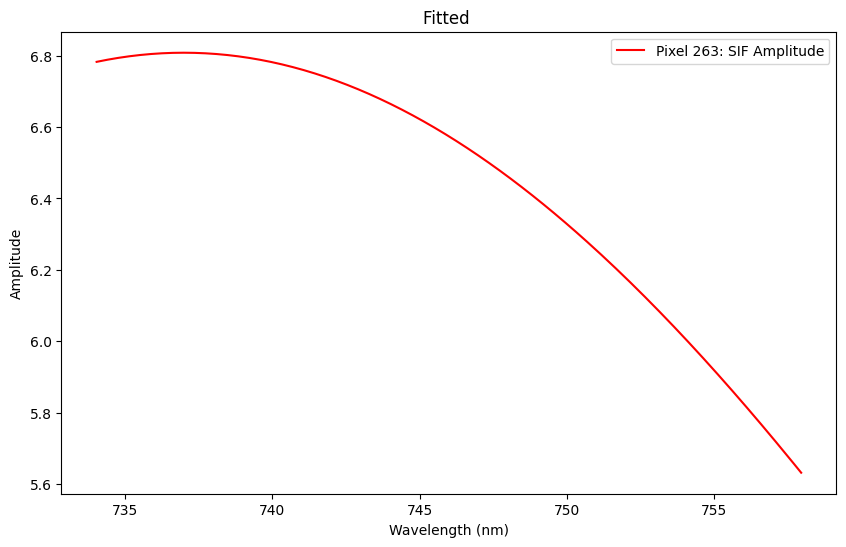

In [17]:
##With albedo fitting and no bounds 
reflectance_observed = africa2.variables['Reflectance'][0, scanline_nocloud2[100], 224, 276:471].data

m = 2
def reflectance_model(lam, *params):

    # Unpack parameters
    a = np.array(params[0:m]) 
    b = np.array(params[m:n+m])
    c = params[n+m]
    
    # Compute the weighted sum over the principal component spectral functions:
    attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
    
    poly_term = sum(a[j] * lam**j for j in range(m))
    baseline = poly_term * np.exp(-attenuation)

    # Gaussian term for the fluorescence component:
    gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
    
    # Geometric factor for the fluorescence attenuation:
    geom_factor = (1 / mu_matrix2[pixel_index]) / ((1 / mu_matrix2[pixel_index]) + (1 / mu_0_matrix2[pixel_index]))
    
    # Fluorescence (SIF) term:
    fluorescence = (np.pi * c * gaussian /( mu_0_matrix2[pixel_index] * solspec)) * np.exp(-attenuation * geom_factor)
    
    # Total modeled reflectance:
    return baseline + fluorescence

# Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
p0 = [0.5]*m + [0.5] * n + [1]

popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0)

print("Fitted parameters:")
print(popt)

# ---- Plot the results ----

R_fit = reflectance_model(wl[ind], *popt)

plt.figure(figsize=(10, 6))
plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
plt.savefig("LM-fitting_PCA_A")
plt.legend()
plt.show()

#Plot transmittance observed and modelled
transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix2[100]) + np.reciprocal(mu_0_matrix2[100]))*tau2[100])
# Extract the fitted PCA coefficients (b0 to b9)
b_fit = np.array(popt[m:n+m])
# Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)

transmitance_modelled = np.exp(-(np.reciprocal(mu_matrix2[100]) + np.reciprocal(mu_0_matrix2[100]))*attenuation_fit)
plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend(loc="best")
plt.savefig("LM_fit_transmitance_PCA_A")
plt.show()
# Pre-compute the Gaussian (same for every pixel if center and width are fixed)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)

# For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
plt.figure(figsize=(10, 6))
plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {scanline_nocloud2[100]}: SIF Amplitude", color='red')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Amplitude")
plt.title("Fitted ")
plt.legend()
plt.savefig("LM_fit_SIF_PCA_A")
plt.show()

In [18]:
f_matrix = components
print(f_matrix.shape)
n = len(f_matrix)
SIF_values_per_scanline2 = []
for pixel_index, i in enumerate(scanline_nocloud2):
    reflectance_observed = africa2.variables['Reflectance'][0, i, 224, 276:471].data
    m = 4
    def reflectance_model(lam, *params):

        # Unpack parameters
        a = np.array(params[0:m]) 
        b = np.array(params[m:n+m])
        c = params[n+m]
        
        # Compute the weighted sum over the principal component spectral functions:
        attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
        poly_term = sum(a[j] * lam**j for j in range(m))
        baseline = poly_term * np.exp(-attenuation)
    
        # Gaussian term for the fluorescence component:
        gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
        # Geometric factor for the fluorescence attenuation:
        geom_factor = (1 / mu_matrix2[pixel_index]) / ((1 / mu_matrix2[pixel_index]) + (1 / mu_0_matrix2[pixel_index]))
        
        # Fluorescence (SIF) term:
        fluorescence = (np.pi * c * gaussian /( mu_0_matrix2[pixel_index] * solspec)) * np.exp(-attenuation * geom_factor)
        
        # Total modeled reflectance:
        return baseline + fluorescence

# Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
    p0 = [0.5]*m + [0.5] * n + [1]

    popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0)

    SIF_values_per_scanline2.append(popt[-1])

(15, 195)


In [ ]:
plt.plot(SIF_values_per_scanline2)
plt.show()
print(np.mean(SIF_values_per_scanline2))

In [19]:
f_matrix = components
print(f_matrix.shape)
n = len(f_matrix)
SIF_values_per_scanline2 = []
for pixel_index, i in enumerate(scanline_nocloud2):
    reflectance_observed = africa2.variables['Reflectance'][0, i, 224, 276:471].data
    def reflectance_model(lam, *params):
    
        # Unpack parameters
        
        b = np.array(params[0:n])
        c = params[n]
        
        # Compute the weighted sum over the principal component spectral functions:
        attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
        # Baseline reflectance term:
        baseline = surf_alb2[pixel_index] * np.exp(-attenuation)
        
        # Gaussian term for the fluorescence component:
        gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
        # Geometric factor for the fluorescence attenuation:
        geom_factor = (1 / mu_matrix2[pixel_index]) / ((1 / mu_matrix2[pixel_index]) + (1 / mu_0_matrix2[pixel_index]))
        
        # Fluorescence (SIF) term:
        fluorescence = (np.pi * c * gaussian /( mu_0_matrix2[pixel_index] * solspec)) * np.exp(-attenuation * geom_factor)
        
        # Total modeled reflectance:
        return baseline + fluorescence
    
    # Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
    p0 = [0] * n + [0]
    
    # Fit the model to the observed reflectance
    popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0)

    SIF_values_per_scanline2.append(popt[-1])

(15, 195)


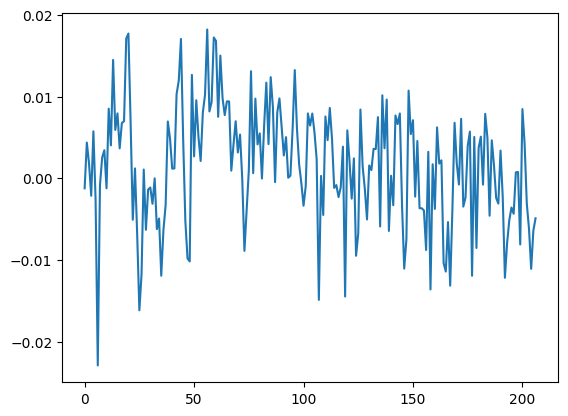

In [20]:
plt.plot(SIF_values_per_scanline2)
plt.show()